# Modifications et analyses sur BDD Master's Recipes JSON

In [1]:
import numpy as np 
import pandas as pd
import json
import re

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

import random
import plotly
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
import plotly.offline as offline
import plotly.graph_objs as go

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import log_loss
from scipy.optimize import minimize
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn import model_selection 

import warnings
warnings.filterwarnings('ignore')

import os

In [2]:
Recipes_data = pd.read_json('./Data_recipes/recipes_final.json', orient='index')

In [3]:
Recipes_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39517 entries, 1 to 2Q3Zpfgt/PUwn1YABjJ5A9T3ZW8xwVa
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         39517 non-null  object
 1   ingredients   39517 non-null  object
 2   instructions  39517 non-null  object
 3   t_recipe      39517 non-null  object
 4   RecipeId      39517 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


In [4]:
Recipes_data.head(20)

,title,ingredients,instructions,t_recipe,RecipeId
1,Slow Cooker Chicken and Dumplings,"[4 skinless boneless chicken breast halves , 2...","Place the chicken, butter, soup, and onion in ...",[Dish with meat],1
2,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ...",[Dish with meat],2
3,Meatloaf,"[1/2 cup packed brown sugar , 1/2 cup ketchup ...",Preheat oven to 350 degrees F (175 degrees C)....,[Dish with meat],3
4,Best Chocolate Chip Cookies,"[1 cup butter, softened , 1 cup white sugar , ...",Preheat oven to 350 degrees F (175 degrees C)....,[Dessert],4
5,Homemade Mac and Cheese Casserole,"[8 ounces whole wheat rotini pasta , 3 cups fr...",Preheat oven to 350 degrees F. Line a 2-quart ...,"[Dish with meat, Pasta, Side Dish]",5
6,Banana Banana Bread,"[2 cups all-purpose flour , 1 teaspoon baking ...",Preheat oven to 350 degrees F (175 degrees C)....,"[Dessert with fruit, Dessert]",6
7,Chef John's Fisherman's Pie,"[For potato crust: , 3 russet potatoes, peeled...",Bring a large saucepan of salted water and to ...,[Dessert],7
8,Mom's Zucchini Bread,"[3 cups all-purpose flour , 1 teaspoon salt , ...",Grease and flour two 8 x 4 inch pans. Preheat ...,[Dessert],8
9,The Best Rolled Sugar Cookies,"[1 1/2 cups butter, softened , 2 cups white su...","In a large bowl, cream together butter and sug...",[Dessert],9
10,Singapore Chili Crabs,"[Sauce: , 1/2 cup ketchup , 1/2 cup chicken br...","Whisk ketchup, chicken broth, egg, soy sauce, ...","[Dish with meat, Dish with Sea Food/fish]",10


In [5]:
print('Maximum Number of Ingredients in a Dish: ',Recipes_data['ingredients'].str.len().max())
print('Minimum Number of Ingredients in a Dish: ',Recipes_data['ingredients'].str.len().min())

Maximum Number of Ingredients in a Dish:  35
Minimum Number of Ingredients in a Dish:  1


In [6]:
trace = go.Histogram(
    x= Recipes_data['ingredients'].str.len(),
    xbins=dict(start=0,end=80,size=1),
   marker=dict(color='#fbca5f'),
    opacity=0.75)
data = [trace]
layout = go.Layout(
    title='Distribution of Recipe Length',
    xaxis=dict(title='Number of ingredients'),
    yaxis=dict(title='Count of recipes'),
    bargap=0.1,
    bargroupgap=0.2)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Word Cloud Function..


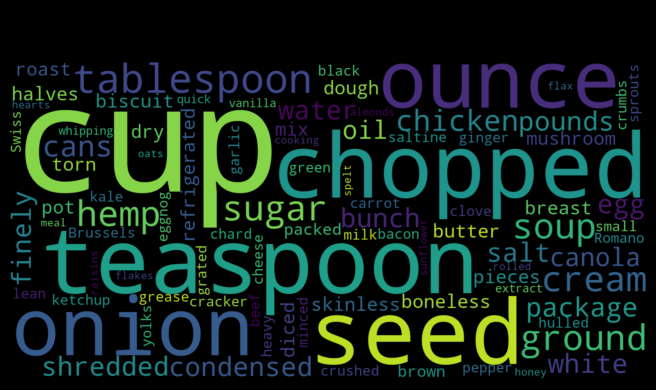

In [7]:
print("Word Cloud Function..")
stopwords = set(STOPWORDS)
size = (20,10)

def cloud(text, title, stopwords=stopwords, size=size):
    """
    Function to plot WordCloud
    Includes: 
    """
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(10.0,10.0)
    mpl.rcParams['font.size']=12
    mpl.rcParams['savefig.dpi']=100
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=stopwords,
                         ).generate(str(text))
    
    # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()
    
# Data Set for Word Clouds
Recipes_data["ingredients"] = Recipes_data.ingredients.apply(lambda x: list(map(str, x)), 1).str.join(' ')
# All
cloud(Recipes_data["ingredients"].values, title= " ", size=[8,5])

In [9]:
trace = go.Table(
                header=dict(values=['Cuisine categories','Number of recipes'],
                fill = dict(color=['#EABEB0']), 
                align = ['left'] * 5),
                cells=dict(values=[Recipes_data.t_recipe.value_counts().index,Recipes_data.t_recipe.value_counts()],
                align = ['left'] * 5))

layout = go.Layout(title='Number of recipes in each cuisine category',
                   titlefont = dict(size = 20),
                   width=1000, height=1000, 
                   paper_bgcolor =  'rgba(0,0,0,0)',
                   plot_bgcolor = 'rgba(0,0,0,0)',
                   autosize = True,
                   margin=dict(l=30,r=30,b=1,t=30,pad=1),
                   )
data = [trace]
fig = dict(data=data, layout=layout)
iplot(fig)

In [ ]:
# Graph avec les recettes par type : camembert? Passer à Tableau/Power BI pour les visualisations

In [ ]:
# Regrouper les catégories ? celles où il y a peu de résultats... 

In [ ]:
# cf les stats sur le rating de ma base PostgreSQL